<a href="https://colab.research.google.com/github/martinsphl/MAI5035/blob/main/TAREFA_1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MAI5035: Task 1.2 by Paulo Martins, Vitória Barbosa and Isaac Saito

## Importing Main Libraries

In [159]:
# Main libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms

# Preprocess data: normalization and ordinal enconder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder

# For Classification Task
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Avoiding warning messages
import warnings
warnings.filterwarnings('ignore')

# Setting a global seed
np.random.seed(7)

## Data Gathering

We created a github public repository to upload the csv dataset and do software versioning. From github public url, we load the data into a pandas dataframe.

**Data Description:**

US Dollar Index dataset ([Available Here](https://www.kaggle.com/datasets/balabaskar/us-dollar-index-data))

1.   Date: Date of observation (time variable in the format Month DD, YYYY)
2.   Price: Dollar index at market close (continuous and positive variable)
3.   Open: Dollar index at market opening (continuous and positive variable)
4.  High: Highest index value observed on the day (continuous, positive variable)
5. Low: Lowest index value observed on the day (continuous, positive variable)
6. Change %: Change in the dollar index compared to the previous day (continuous variable in percent)

In [160]:
# Defining the url of each dataset
dataset_url = 'https://raw.githubusercontent.com/martinsphl/MAI5035/refs/heads/main/US%20Dollar%20Index%20Historical%20Data.csv'

# Creating pandas dataframe from each dataset
df = pd.read_csv(dataset_url, names=['date', 'last_price', 'first_price', 'biggest_price', 'lowest_price', 'perc_variation'], skiprows=1, delimiter=',')

In [161]:
# Just checking that the dataframe was loaded correctly from the Github URL
print(df.head(5).to_markdown())

|    | date         |   last_price |   first_price |   biggest_price |   lowest_price | perc_variation   |
|---:|:-------------|-------------:|--------------:|----------------:|---------------:|:-----------------|
|  0 | Jan 02, 2001 |       108.77 |        109.33 |          109.65 |         108.64 | -0.72%           |
|  1 | Jan 03, 2001 |       110.17 |        108.59 |          110.34 |         108.09 | 1.29%            |
|  2 | Jan 04, 2001 |       108.81 |        110.3  |          110.4  |         108.51 | -1.23%           |
|  3 | Jan 05, 2001 |       108.42 |        108.64 |          109.31 |         108.26 | -0.36%           |
|  4 | Jan 08, 2001 |       108.86 |        108.33 |          109.19 |         108.23 | 0.41%            |


## Data Exploration
On this stage, we will get knowlodge on data. So, we'll check the type of columns and how many null values there are; since this point, all next exploratory analysis will be under numerics columns: check descriptive statistics, density distribution and outliers occurrences by IQR.

In [162]:
# Checking the data type of each column and if there are missing values
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5623 entries, 0 to 5622
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            5623 non-null   object 
 1   last_price      5623 non-null   float64
 2   first_price     5623 non-null   float64
 3   biggest_price   5623 non-null   float64
 4   lowest_price    5623 non-null   float64
 5   perc_variation  5623 non-null   object 
dtypes: float64(4), object(2)
memory usage: 263.7+ KB
None


To increase the possibilities, we will do some feature engineering, creating 3 new columns (day, month and year) and transform the perc_variation column from object to float64.

In [163]:
# Ordering the data
df.sort_values(by=['date'], ascending=True)

# Create 3 new features
df['date'] = pd.to_datetime(df['date'])
df['day'] = df.date.dt.day
df['month'] = df.date.dt.month
df['year'] = df.date.dt.year

# Convert date column in epoch timestamp
#df['epoch_time'] = df['date'].astype('int64') // 10**9

# Remove '%'symbol from pec_variation column
df['perc_variation'] = df['perc_variation'].str[:-1]
df['perc_variation'] = df['perc_variation'].astype(float)

df.drop(columns=['date'], axis=1, inplace=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5623 entries, 0 to 5622
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   last_price      5623 non-null   float64
 1   first_price     5623 non-null   float64
 2   biggest_price   5623 non-null   float64
 3   lowest_price    5623 non-null   float64
 4   perc_variation  5623 non-null   float64
 5   day             5623 non-null   int32  
 6   month           5623 non-null   int32  
 7   year            5623 non-null   int32  
dtypes: float64(5), int32(3)
memory usage: 285.7 KB
None


In [164]:
# Checking the Descriptive Statistics of numerics columns
print(df.describe())

        last_price  first_price  biggest_price  lowest_price  perc_variation  \
count  5623.000000  5623.000000    5623.000000   5623.000000     5623.000000   
mean     90.503363    90.501930      90.825543     90.184988        0.001279   
std      10.689395    10.689031      10.721918     10.658198        0.483794   
min      71.330000    71.330000      71.690000     70.700000       -3.020000   
25%      81.440000    81.430000      81.720000     81.180000       -0.270000   
50%      89.990000    89.990000      90.250000     89.690000        0.000000   
75%      96.950000    96.940000      97.250000     96.625000        0.270000   
max     120.900000   120.760000     121.020000    119.860000        2.560000   

               day        month         year  
count  5623.000000  5623.000000  5623.000000  
mean     15.718122     6.475013  2011.425929  
std       8.786412     3.429169     6.264974  
min       1.000000     1.000000  2001.000000  
25%       8.000000     4.000000  2006.000000

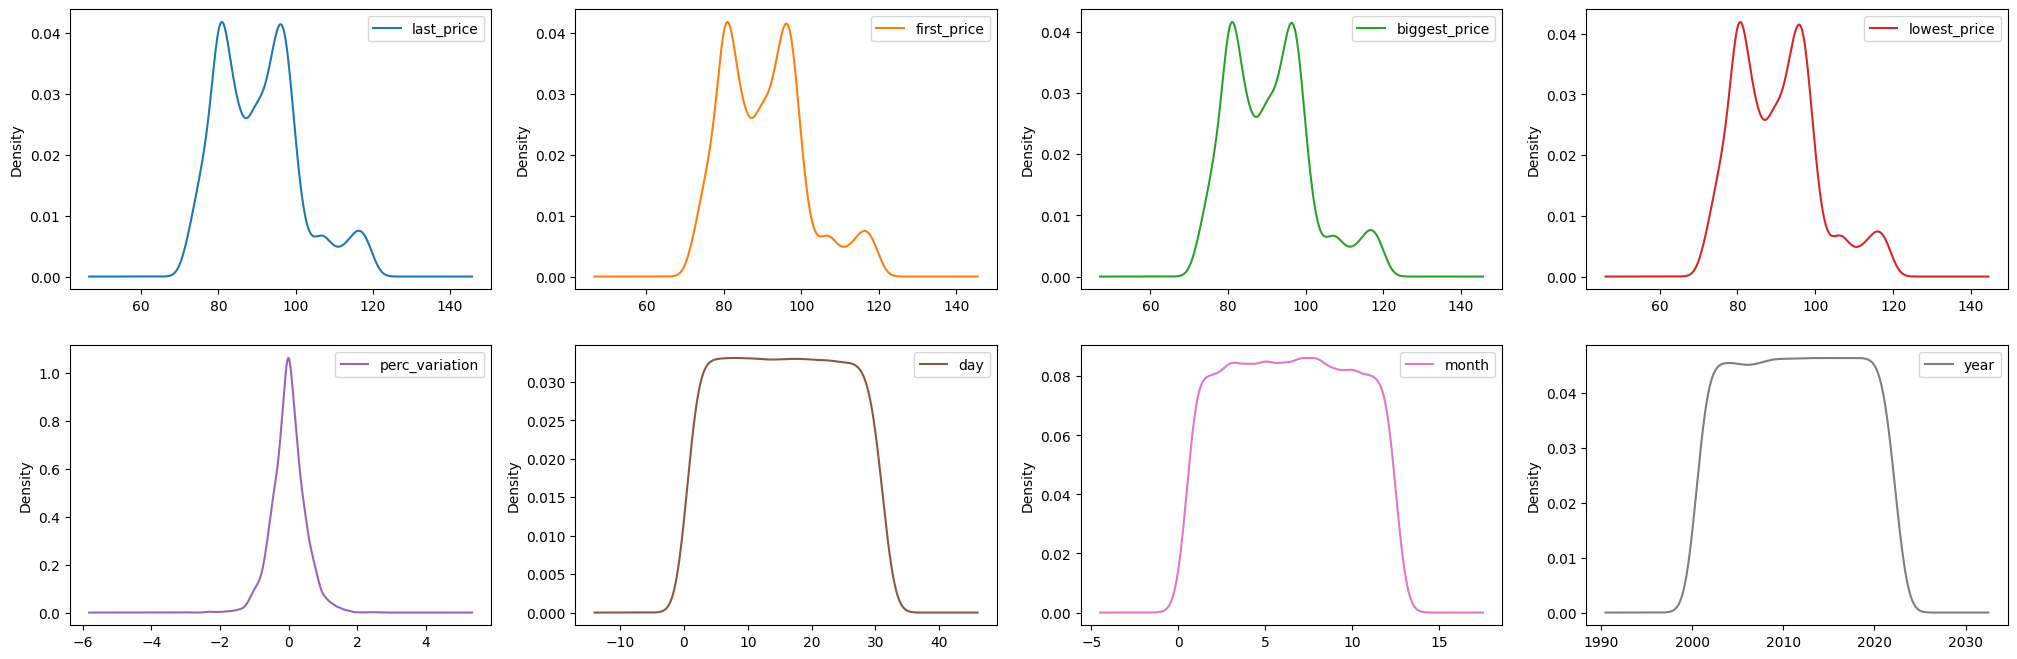

In [165]:
# Now let's check the density distribution of numeric columns
df.plot(kind = 'density', subplots = True, layout = (2,4), sharex = False, figsize = (25, 8))
plt.show()

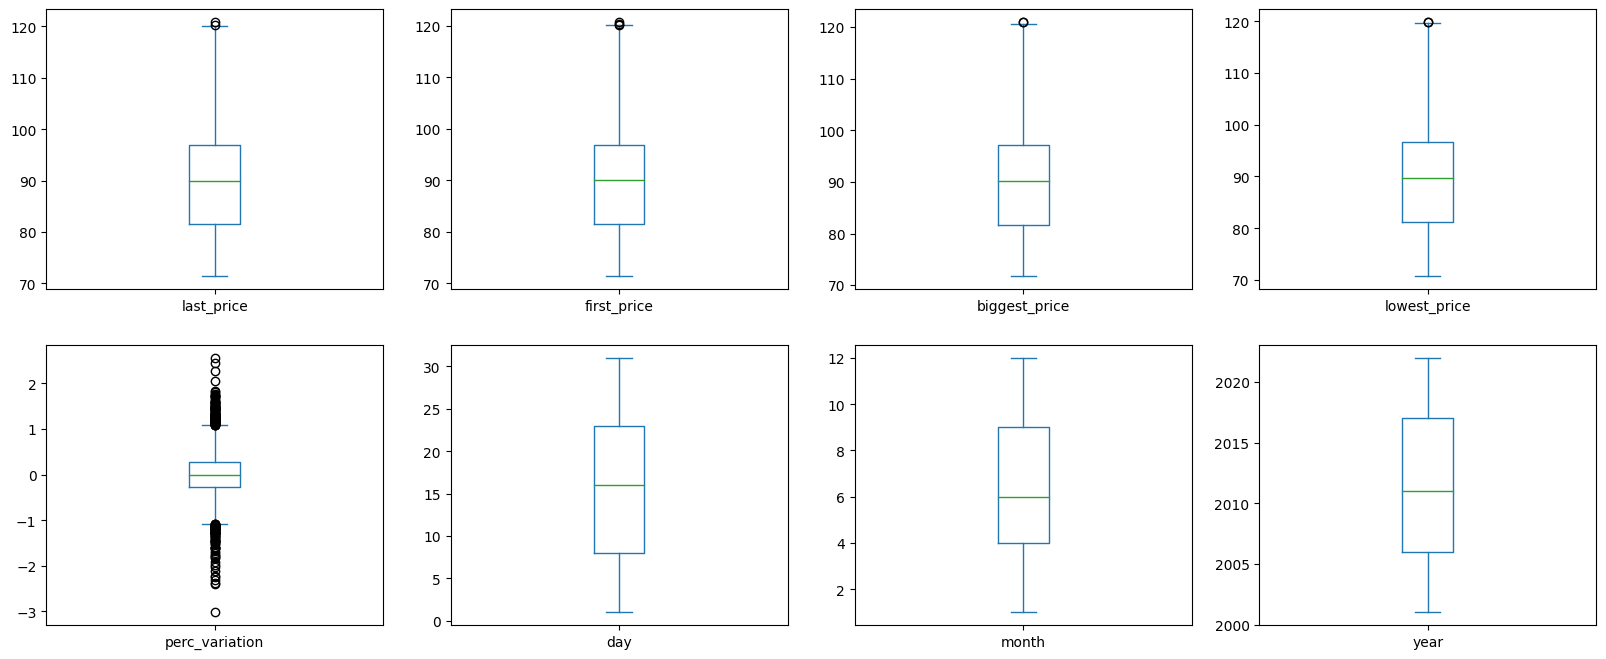

In [166]:
# Finally verifying if there is any outlier values based on IQR technique
df.plot(kind = 'box', subplots = True, layout = (2,4), sharex = False, sharey = False, figsize = (20,8))
plt.show()

We know that the currency market is volatile and perhaps the discrepant values identified in the perc_variation column are a reflection of the market. Just for verification purposes, we will recalculate all the values in this column according to the official documentation

In [167]:
df['calculated_perc_variation'] = 100 * ((df['last_price'] / df['last_price'].shift()) - 1)
df.loc[0, 'calculated_perc_variation'] = df.loc[0, 'perc_variation']
print(df[['perc_variation', 'calculated_perc_variation']].describe())

       perc_variation  calculated_perc_variation
count     5623.000000                5623.000000
mean         0.001279                   0.001261
std          0.483794                   0.483741
min         -3.020000                  -3.018085
25%         -0.270000                  -0.272645
50%          0.000000                   0.000000
75%          0.270000                   0.270876
max          2.560000                   2.555828


Based on the descriptive statistics above, we can see that the change was not very significant. In general, the data has changed from the fourth decimal place. Since we've to decide on one of the two columns, we'll keep the value of calculated_perc_variation by replacing the values in perc_variation.

In [168]:
# Just deciding on one of the two
df['perc_variation'] = df['calculated_perc_variation']
df.drop(columns=['calculated_perc_variation'], axis=1, inplace=True)

As we expected, this kaggle dataset has been pre-processed by someone and this version looks good enough to go ahead without any additional pre-processing, such as filling in missing values or removing outliers.

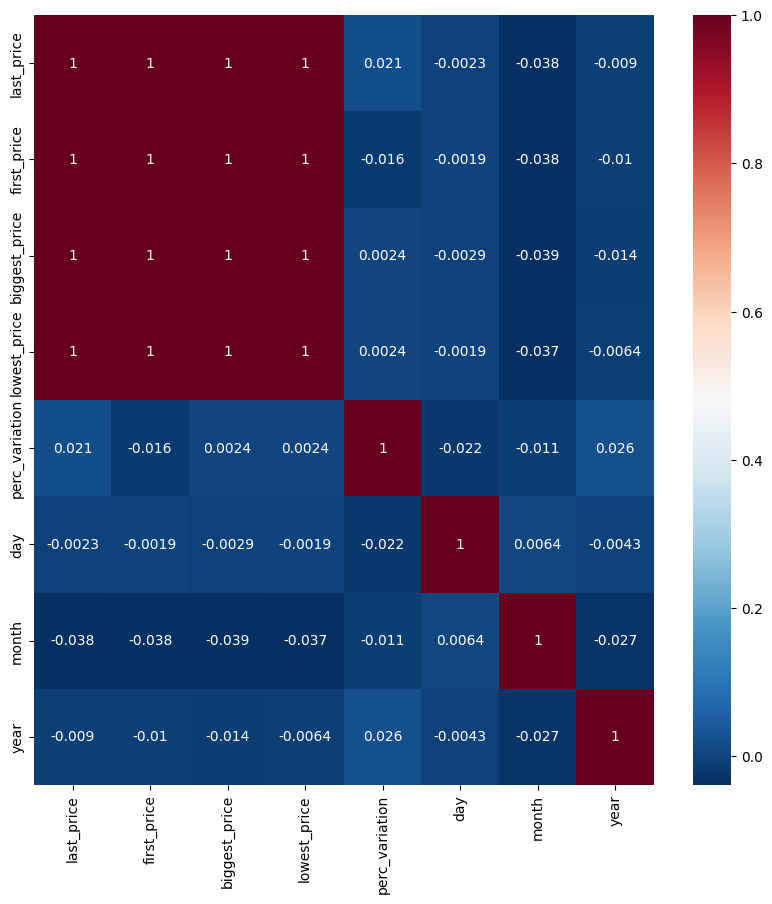

In [169]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True, cmap='RdBu_r')
plt.show()

## Problem definition

At this point, we only have a clean dataframe from kaggle and did some feature engineering. In fact, not much pre-processing was required. Based on this, we decided to create three different questions to apply *machine learning*:

1. Predict the perc. variation in 7 days ahead
2. Predict the perc. variation in 14 days ahead
3. Predict the perc. variation in 28 days ahead

### Feature Selection and Normalization

As you can see above, there are four strongly related columns, so we have to decide on one of them. We selected first_price because it is weakly related to other columns. Finally, we'll normalize the column values.

In [175]:
list_features = ['first_price', 'perc_variation', 'day', 'month', 'year']
df_normalized = df.loc[:, list_features].copy()

scaler = MinMaxScaler()
for i in range(0,df_normalized.shape[1]):
  df_normalized.iloc[:, i] = scaler.fit_transform(df_normalized.iloc[:, [i]])

At this point, we expect that there are only uncorrelated variables (close to 0) to feed the linear regression algorithm. Let's check it:

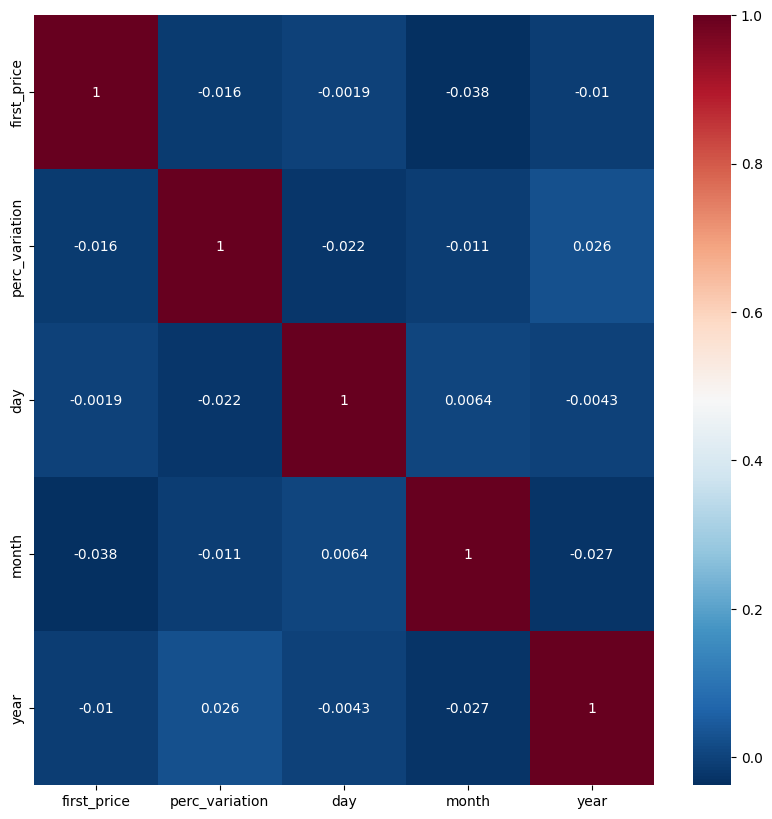

In [177]:
plt.figure(figsize=(10, 10))
sns.heatmap(df_normalized.corr(), annot=True, cmap='RdBu_r')
plt.show()

### Forecast Prediction with Linear Regression